# Launch Sagemaker Pipeline

In [2]:
import boto3
import sagemaker
from datetime import date
from sagemaker.workflow.parallelism_config import ParallelismConfiguration
import utils

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## General parameters

In [3]:
 # By default
region = boto3.Session().region_name
role = sagemaker.get_execution_role()

# Use own bucket and prefix
s3_bucket_nps = 'iberia-data-lake' # In this case: iberia-data-lake
s3_bucket_nps_prefix = 'customer/nps_explainability_model' # In this case: sagemaker/sagemaker-template

s3_bucket_lf = 'ibdata-prod-ew1-s3-customer'
s3_bucket_lf_prefix = 'customer/load_factor_to_s3_nps_model'

# Environment (sbx or prod pipeline)
environment = "develop"
environment_ppl = "prod" if environment == "production" else "sbx"

# Config file
configuration = utils.read_config_data()

# Parameters
str_execution_date = '2024-04-12' # Change
is_last_date = "0" # Optional
model_version = configuration.get("MODEL_VERSION")
vertical = configuration.get("VERTICAL")
s3_path_write = "customer/nps_explainability_model/sbx"


insert_date_ci='2024-04-09'
s3_path_read_nps = 'customer/nps_surveys/export_historic'
s3_path_read_lf = "customer/load_factor_to_s3_nps_model"



## Pipeline definition

### Create pipeline execution updating code from sagemaker repository

In [4]:
from production.pipelines_code.pipeline import get_pipeline as pipeline_definition

pipeline_name = (
    f"ibdata-{vertical}-{model_version.lower()}-{environment_ppl}-ppl"
)
base_job_prefix = pipeline_name

pipe_definition = pipeline_definition(
    region=region,
    role=role,
    default_bucket='iberia-data-lake',
    default_bucket_prefix='customer/nps_explainability_model/sbx/pipeline',
    pipeline_name=pipeline_name,
    base_job_prefix=base_job_prefix
)
pipe_definition.upsert(role_arn=role)


INFO:sagemaker.processing:Uploaded None to s3://iberia-data-lake/customer/nps_explainability_model/sbx/pipeline/ibdata-customer-nps-client-model-sbx-pp-2024-07-10-11-49-16-989/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://iberia-data-lake/customer/nps_explainability_model/sbx/pipeline/ibdata-customer-nps-client-model-sbx-pp-2024-07-10-11-49-16-989/source/runproc.sh
INFO:sagemaker.processing:Uploaded None to s3://iberia-data-lake/customer/nps_explainability_model/sbx/pipeline/ibdata-customer-nps-client-model-sbx-pp-2024-07-10-11-49-17-506/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://iberia-data-lake/customer/nps_explainability_model/sbx/pipeline/ibdata-customer-nps-client-model-sbx-pp-2024-07-10-11-49-17-506/source/runproc.sh
INFO:sagemaker.processing:Uploaded None to s3://iberia-data-lake/customer/nps_explainability_model/sbx/pipeline/ibdata-customer-nps-client-model-sbx-pp-2024-07-10-11-49-17-667/source/sourcedir.tar.gz


{'PipelineArn': 'arn:aws:sagemaker:eu-west-1:077156906314:pipeline/ibdata-customer-nps-client-model-sbx-ppl',
 'ResponseMetadata': {'RequestId': '977c886d-c9ae-488e-a345-866c8570de6b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '977c886d-c9ae-488e-a345-866c8570de6b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '108',
   'date': 'Wed, 10 Jul 2024 11:49:19 GMT'},
  'RetryAttempts': 0}}

In [5]:
pipeline_name

'ibdata-customer-nps-client-model-sbx-ppl'

### Execute pipeline with parameters

In [6]:
# This cell starts an execution of the previous pipeline created
execution = pipe_definition.start(
    parallelism_config=ParallelismConfiguration(max_parallel_execution_steps=4).to_request(),
    parameters=dict(
        str_execution_date=str_execution_date,
        is_last_date=is_last_date,
        s3_path_write=s3_path_write,
        s3_path_read_nps=s3_path_read_nps,
        s3_path_read_lf=s3_path_read_lf,        
        use_type='predict',
    )
)
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:eu-west-1:077156906314:pipeline/ibdata-customer-nps-client-model-sbx-ppl',
 'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:077156906314:pipeline/ibdata-customer-nps-client-model-sbx-ppl/execution/i4nkeff8giyg',
 'PipelineExecutionDisplayName': 'execution-1720612160173',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 7, 10, 11, 49, 20, 118000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 7, 10, 11, 49, 20, 118000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:eu-west-1:077156906314:user-profile/d-8rnxtw3g36nb/customer-diego-rivera',
  'UserProfileName': 'customer-diego-rivera',
  'DomainId': 'd-8rnxtw3g36nb',
  'IamIdentity': {'Arn': 'arn:aws:sts::077156906314:assumed-role/ibdata-aip-role-sagemaker-customer-user/SageMaker',
   'PrincipalId': 'AROARD5XI6VFDJH3ORBAM:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:eu-west-1:077156906314:user-profile

In [7]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed


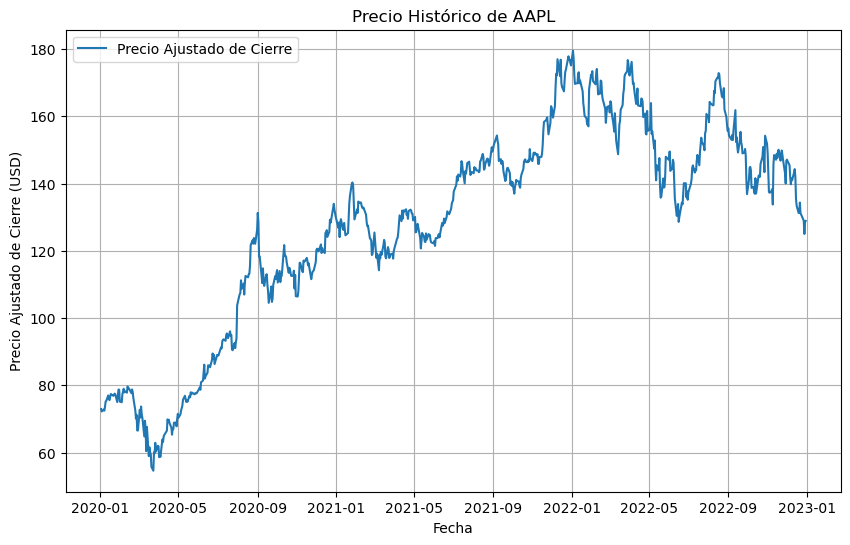

count    755.000000
mean       0.001024
std        0.023266
min       -0.128647
25%       -0.011103
50%        0.000613
75%        0.014154
max        0.119808
Name: Daily Return, dtype: float64


In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Descargar datos históricos de una acción (por ejemplo, Apple)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Calcular retornos diarios
data['Daily Return'] = data['Adj Close'].pct_change()

# Visualizar los datos
plt.figure(figsize=(10, 6))
plt.plot(data['Adj Close'], label='Precio Ajustado de Cierre')
plt.title(f'Precio Histórico de {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar estadisticas básicas
print(data['Daily Return'].describe())
